In [1]:
import httplib
import json

def tmdb_get_latest_movie():
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/latest?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_imdb_id(imdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/find/tt"+str(imdb_id)+"?api_key="+api_key+"&external_source=imdb_id", 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_tmdb_id(tmdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/"+str(tmdb_id)+"?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_adult(text):
    return json.loads(text)['adult']

def tmdb_get_collection(text):
    return json.loads(text)['belongs_to_collection']

def tmdb_get_budget(text):
    return json.loads(text)['budget']

def tmdb_get_genre(text):
    dict_list = json.loads(text)['genres']
    genre_list = []
    for sub_dict in dict_list:
        genre_list.append(sub_dict['name'])
    return genre_list

def tmdb_get_tmdb_id(text):
    return json.loads(text)['id']

def tmdb_get_imdb_id(text):
    return json.loads(text)['imdb_id'][2::]

def tmdb_get_title(text):
    return json.loads(text)['title']

def tmdb_get_overview(text):
    return json.loads(text)['overview']

def tmdb_get_production_companies(text):
    return json.loads(text)['production_companies']

def tmdb_get_production_countries(text):
    return json.loads(text)['production_countries']

def tmdb_get_release_date(text):
    return json.loads(text)['release_date']

def tmdb_get_runtime(text):
    return json.loads(text)['runtime']

def tmdb_get_spoken_languages(text):
    return json.loads(text)['spoken_languages']

def tmdb_get_poster_url(text):
    url = json.loads(text)['poster_path']
    if url == None:
        return None
    else:
        return "https://image.tmdb.org/t/p/w500" + json.loads(text)['poster_path']

def tmdb_exist(text):
    error_msg = "The resource you requested could not be found."
    if error_msg in text:
        return False
    else:
        return True

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
from os.path import join, expanduser
from os import listdir
from skimage import io
import pickle
import sys
import time
from skimage import transform

In [21]:
# get file list
dir_path = expanduser("~/tmdb_movie/")
movie_file_list = listdir(dir_path)
poster_list = []
y = []

# get posters of all movies
for index, movie_file in enumerate(movie_file_list[0:1000]):
    # get movie text
    with open(join(dir_path, movie_file), "rb") as myfile:
        movie_text = pickle.load(myfile)
    # print progress
    print "\r",index,
    sys.stdout.flush()
    # get poster url
    poster_url = tmdb_get_poster_url(movie_text)
    # check if url exists
    if poster_url == None:
        continue
    else:
        try:
            # get poster
            poster = io.imread(poster_url)
            if "Thriller" in tmdb_get_genre(movie_text):
                y.append(1)
            else:
                y.append(0)
        except:
            print poster_url
            break
        #time.sleep(0.251)
        poster_list.append(poster)

999


In [4]:
# http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb5(im):
    im.resize((im.shape[0], im.shape[1], 1))
    return np.repeat(im.astype(np.uint8), 3, 2)

In [5]:
# prepare matrix
poster_oneline_list = []
for poster in poster_list:
    # if black and white poster
    if len(poster.shape) < 3:
        poster = to_rgb5(poster)
    # if black and white poster with third dimension
    elif poster.shape[2] < 3:
        poster = to_rgb5(poster)
    
    # resize image by skimage.transform.resize
    new_poster = transform.resize(poster, (500, 500, 3))
    poster_oneline = new_poster[0:500, 0:500, :].reshape((1, -1))
    if poster_oneline.shape <> (1, 750000):
        print new_poster.shape
        io.imshow(new_poster)
    poster_oneline_list.append(poster_oneline)

In [6]:
poster_cat = np.concatenate(poster_oneline_list, axis = 0)
print poster_cat.shape
# run pca
from sklearn.decomposition import PCA
pca_model = PCA().fit(poster_cat)
poster_cat_pca = pca_model.transform(poster_cat)
print poster_cat_pca.shape

(989, 750000)
(989, 989)


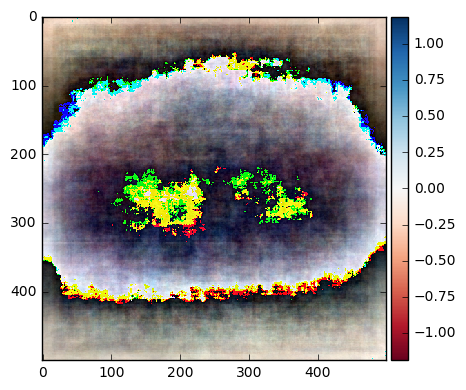

In [10]:
pca_1 = pca_model.components_[3].reshape((500, 500, 3))*500
io.imshow(pca_1)

In [22]:
print len(y)
print poster_cat.shape

989
(989, 750000)


In [23]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model.fit(poster_cat, y)
y_hat = model.predict(poster_cat)
print np.mean([e1 == e2 for (e1, e2) in zip(y_hat, y)])

0.726996966633
